# Optimizing Camera Placement for Emergency Prevention and Response

Scientific mentors: Matteo Vandelli and Daniele Dragoni (Leonardo S.p.a.)

Here we propose a problem of interest in this field: an optimization problem involving the placement of hyperspectral cameras used in the prevention of natural disasters and in emergency response.
The formulation of the problem is a simplified one, which has important connections with real-world scenarios.

Simplifying assumptions are: 
- The field of view of the cameras is isotropic, while in reality it depends on the morphology of the territory.
- The risk of a natural disaster occurring on the territory of choice is homogeneous.

We have $N$ candidate sites and $C$ available antennas (we assume that $C=0$ means no constraint).

The corresponding Ising problem has the following form, in terms of the Ising binary variables $z_i \in \{-1, 1\}$:

\begin{align}
H_C(z) &= \sum\limits_{i<j}^N W_{ij} z_i z_j - \xi \sum\limits_{i=1}^N A_i z_i\\
& \text{s.t.} 
\hspace{1cm}\left\{\begin{matrix}
\sum\limits_{i=1}^N z_i = N - 2C    \hspace{1.5cm}&\text{if $C>0$}\\
\text{none}   &\text{if $C=0$}
\end{matrix}\right.
\end{align}



where 
- $W_{ij}$ is the overlap area between the fields of view of two cameras,
- $A_i$ is the area covered by a camera at site $i$,
- $\xi$ is a positive real number to be suitably tuned.

This problem has been proposed in Ref.[1] in the context of antenna placement.
This "spin ILP" problem can be written in the unconstrained form:
\begin{align}
H_P(z) = H_C(z) + P\left(\sum\limits_{i=1}^N z_i - \delta N\right)^2
\end{align}
where $P \geq 0$ is a penalty term that has to be chosen large enough to obtain a ground state with the correct number of cameras, but not too large otherwise the optimization becomes more complicated. In this case, $P=0$ means that the problem is unconstrained.

Your job is to study the performances of the TN algorithms (variational and/or imaginary-time) for **both** the *constrained* and *unconstrained* cases.


[1] *Evaluating the Practicality of Quantum Optimization Algorithms for Prototypical Industrial Applications*,
M. Vandelli, A. Lignarolo, C. Cavazzoni, D. Dragoni, arXiv:2311.11621 (2023)


In [3]:
# Loading libraries to handle the problem
from ocp import *

In [37]:
# number of sites
# N = 10
sizes = [16]

xi_list = [.25]

# number of cameras
C = 1
P = 0.0

# side of the square defining the simplified model
a = 10

num_shots = 100 # shots for measuring the bitstring
max_bond_dim = 32
cut_ratio = 1e-8
max_iter = 500
tn_type = 6 # (5)TTN, (6)MPS
tensor_backend = 2
statics_method = 4 #1 : sweep, 2 : sweep with space expansion, 4 : imaginary time evolution with TDVP space expansion
                #5 : imaginary time evolution with TDVP single-site, 33 : imaginary nearest-neighbor TEBD.

tau = 0.1
rel_deviation = 1e-8 #tolerance for convergence

seed=42

random_sweep = False
sweep_order=None
# sweep_order=[]
# for i in reversed(range(int(np.log2(sizes[0])))):
#     for j in range(int(2**(i+1))):
#         sweep_order.append((i,j))
# sweep_order = sorted(sweep_order, key=lambda x: x[1])
# print("sweep_order:", sweep_order)
# random.shuffle(sweep_order)



In [43]:
np.random.seed(seed)

chi_list = [8, 16, 32, 64, 128]
for chi in chi_list:
    print("max. bond dimension = ", chi)
    max_bond_dim = chi
    params, dlist, mlist, slist = everythin_else(sizes, C, P, xi_list, a, seed, tau, max_bond_dim, cut_ratio, max_iter, 
                                                statics_method, tn_type, tensor_backend, num_shots, rel_deviation, random_sweep)
    results = []
    tn_time_list = []
    tn_energy_list = []
    bit_string_list = []
    for ii, elem in enumerate(params):
        print('params = ', elem)
        
        # run the simulation
        start_time = time.time()
        
        slist[ii].run(elem, delete_existing_folder=True, nthreads=1)
        
        dt_tn = time.time() - start_time
        # get the results
        results.append( slist[ii].get_static_obs(elem) )

        energy = results[ii]['energy']
        proj = results[ii]['projective_measurements']

        tn_energy_list.append(energy)
        tn_time_list.append(dt_tn)
        
        bit_strings=[]
        cnt=0
        for bit in proj.keys():
            bit_strings.append([*bit])
            plot_antennas(dlist[ii], status=bit_strings[cnt])
            # plt.savefig('camera_placement_N'+str(elem['N'])+'_xi'+str(elem['xi'])+'_var'+str(statics_method)+'_.pdf',bbox_inches='tight')
            cnt+=1
        bit_string_list.append(bit_strings)
        print("energy = ", energy)
        print("bit_strings = ", bit_strings)
        print("runtime = ", dt_tn)
        print("no. antennas = ", len(bit_strings[0])-np.sum(np.array(bit_strings[0], dtype=int)))


max. bond dimension =  8
params =  {'N': 16, 'xi': 0.25}
Starting simulation input


KeyboardInterrupt: 

In [8]:
# from time.time import datetime
tn_file = open('tn_mps_var'+str(statics_method)+'.dat','a')
# print ('# [N, xi, seed, time(s), cost, alpha, solution]:',file=tn_file)
print ('# [N, xi, seed, time(s), cost, solution]:',file=tn_file)
for ii, elem in enumerate(params):
    # print(elem['N'], elem['xi'],seed,tn_time_list[ii], tn_energy_list[ii], tn_energy_list[ii]/ed_energy[ii], bit_string_list[ii],file=tn_file)
    print(elem['N'], elem['xi'], seed, tn_time_list[ii], tn_energy_list[ii], bit_string_list[ii],file=tn_file)

tn_file.close()

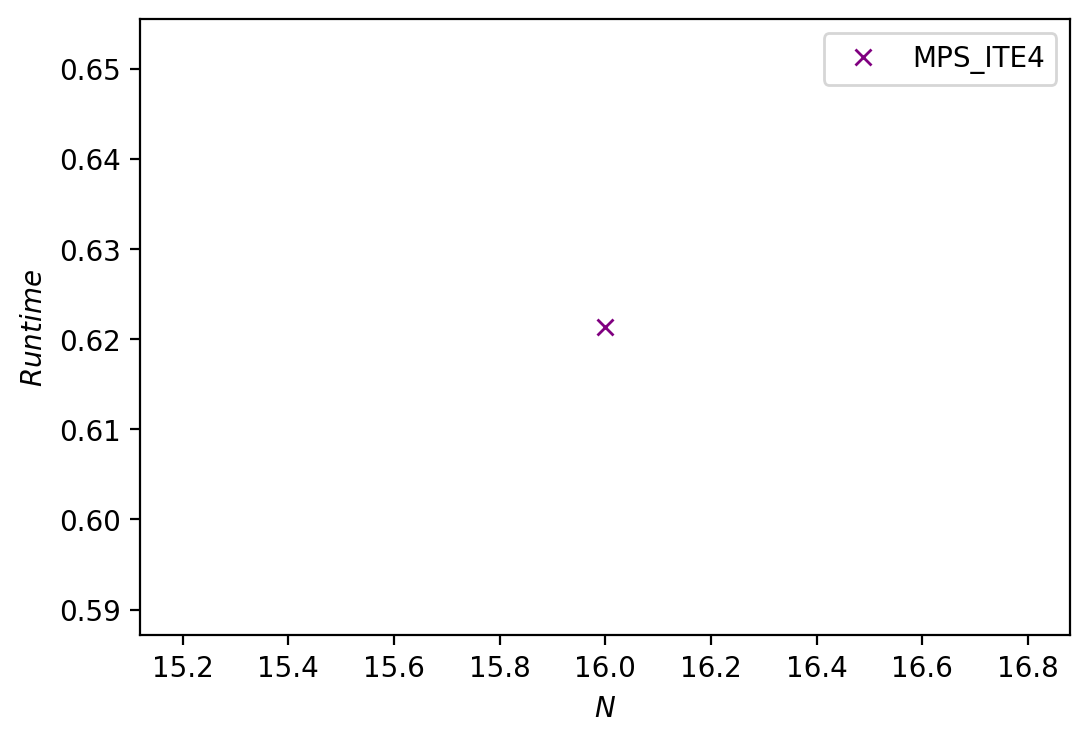

In [10]:
mpl.rcParams["figure.dpi"] = 200
plt.rcParams["figure.figsize"] = (6,4)
plt.plot(sizes, tn_time_list, 'x', color="purple",label='MPS_ITE4')
# plt.plot(sizes, ed_time, '+', color="green",label='ED')
plt.legend()
plt.xlabel("$N$")
plt.ylabel("$ Runtime $")
plt.savefig('runtime.png',bbox_inches='tight')

Text(0, 0.5, 'Cost')

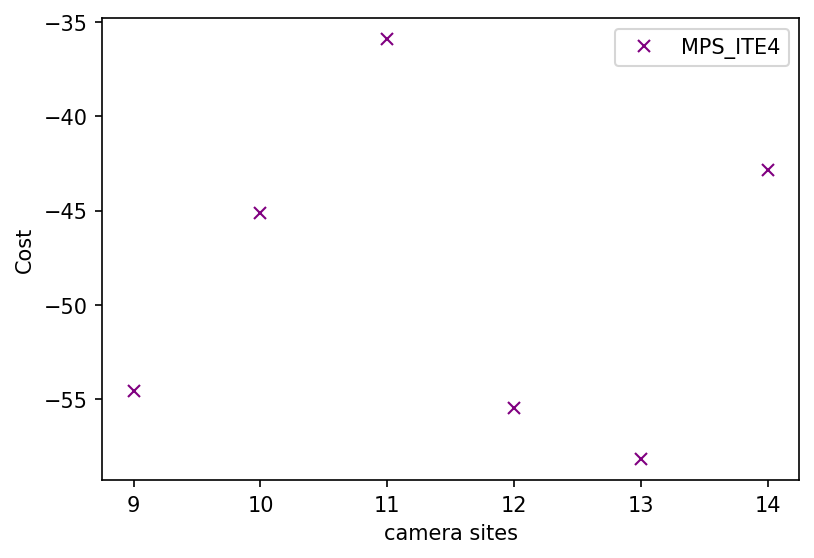

In [7]:
mpl.rcParams["figure.dpi"] = 200
plt.rcParams["figure.figsize"] = (6,4)
plt.plot(sizes, tn_energy_list, 'x', color="purple",label='MPS_ITE4')
# plt.plot(sizes, ed_energy, '+', color="green",label='ED')
plt.legend()
plt.xlabel("$N$")
plt.ylabel("$ Cost $")
plt.savefig('energy.png',bbox_inches='tight')

## Comments on the tasks

The tasks for this project are outlined in the README file. Here are a few more hints to solve the problem. Of course, feel free to express your creativity, if you find better performance indicators.


- This project is not devoted to model derivation/setup, but mostly on the analysis of the results. The main focus of this project is to analyse the performance scaling as a function of the dimensionality of the system. A plot of "metric" vs $N$ should be provided for each selected metrics. An estimate of the scaling of the various metrics in the Big-O notation should be provided (polynomial, exponential...?). What are the differences in terms of runtime and accuracy between the constrained and unconstrained cases?


- We start from a small instance with $N=16$, that you should be able to address directly with brute-force search (BF) in a matter of seconds. A problem with $N=32$ should also be solvable with BF, but could require minutes to hours depending on the efficiency/parallelism of your BF code. 


- The TN solver should work up to $N \approx 1000$ qubits. In the current version, the tensor-network solver can handle variables which are powers of 2, so the number of variables should be set to $N = 2^n$. For the purpose of this Hackathon, we suggest to explore powers of two at least up to $N=512$ ($n=9$).


- Imaginary-time and variational solvers have both internal hyper-parameters. Be sure to tune them properly to achieve good convergence!


- If you decide to use a commercial code (CPLEX or GUROBI), you will be able to get the exact solution up to $N=256$.


- If a metric requires the extraction of pseudorandom samples, please provide some estimate of the sampling uncertainty.


### Suggestion of performance metrics

The performance metrics of TN should include: 
- runtime of your solution
- best generated solution
- cost of the best solution
- distribution of the sampled solutions

For instances that you can solve exactly, you can also access the (single-instance) approximation ratio:

\begin{align}
\alpha(E) = \frac{E}{H_{\rm min}}
\end{align}

or 

\begin{align}
\alpha(E) = 1- \frac{E-H_{\rm min}}{H_{\rm max} - H_{\rm min}}
\end{align}

so you can compute:
- approximation ratio of expectation value ($E = \langle H \rangle$)
- approximation ratio of the best generated solution ($E = E_{\rm TN-best}$)
- probability of getting the exact/best solution 


HINT: Would you include the penalty when estimating $\alpha$? 


#### Thanks for your attention and have fun!